In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
import caffe
import cv2
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

In [2]:
PATCH_SIZE = 100

WEIGHTS_FILE = '/home/jing/Documents/CNN_tabletennis/end2end_regress_iter_20000.caffemodel'
DEPLOY_FILE = '/home/jing/Documents/CNN_tabletennis/models/end2end_regression_deploy.prototxt'
MEAN_FILE = '/home/jing/Documents/CNN_tabletennis/data/mean.npy'

In [3]:
mu = np.load(MEAN_FILE)
mu = mu.mean(1).mean(1)
print mu

net = caffe.Net(DEPLOY_FILE, WEIGHTS_FILE, caffe.TEST)

transformer = caffe.io.Transformer({'data':net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))#nChannels w h?
transformer.set_mean('data', mu)
transformer.set_raw_scale('data', 255)
transformer.set_channel_swap('data', (2,1,0))#RGB to BGR

[ 116.1987664    86.25564234   87.22195852]


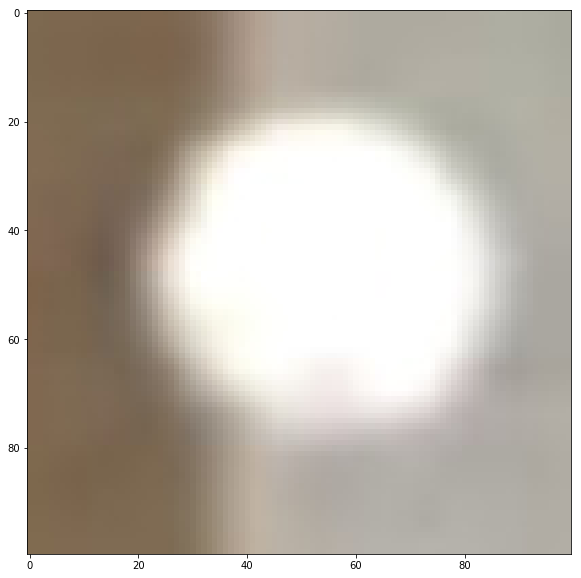

In [4]:
#img_name = '/home/jing/Documents/TableTennis/TableTennis/build/tabletennis_test/0015R024502.jpg'
#prob_name = '/home/jing/Documents/TableTennis/TableTennis/build/tabletennis_test/0015R024502.prob.jpg'
img_name = '/media/jing/0C4F0EAC0C4F0EAC/project/tabletennis/tabletennis/0001L040802.jpg'
prob_name = '/media/jing/0C4F0EAC0C4F0EAC/project/tabletennis/tabletennis/0001L040802.prob.jpg'

#batch_size = net.blobs['data'].data.shape[0]

image = caffe.io.load_image(img_name)
image = cv2.resize(image, (PATCH_SIZE, PATCH_SIZE))
plt.imshow(image)

0.000365763 0.999901


(-0.5, 49.5, 49.5, -0.5)

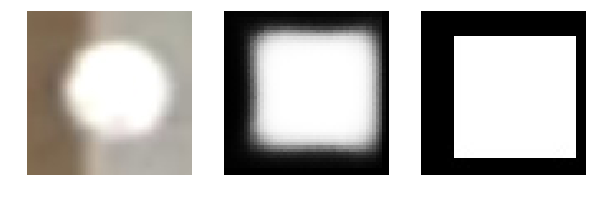

In [5]:
transformed_image = transformer.preprocess('data', image)
net.blobs['data'].data[0,...] = transformed_image

output = net.forward()

#sodlt = output['sodlt_norm'][0][0]
sodlt = net.blobs['sodlt_norm'].data[0][0]
#sodlt = 1/(1+np.exp(-sodlt[0]))
print np.min(sodlt), np.max(sodlt)

plt.subplot(1, 3, 1)
plt.imshow(image); plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sodlt); plt.axis('off')
plt.subplot(1, 3, 3)

prob = caffe.io.load_image(prob_name)
plt.imshow(prob); plt.axis('off')

{'bbox_pred': array([[ 14.23451138,  10.36327744,  42.49469376,  37.13496399]], dtype=float32), 'prob_max': array([ 0.99990106], dtype=float32)}
[  9.   6.  47.  42.]
0.999901


(-0.5, 49.5, 49.5, -0.5)

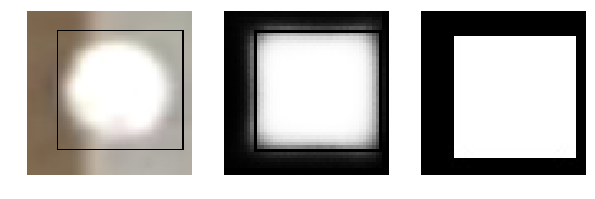

In [10]:
transformed_image = transformer.preprocess('data', image)
net.blobs['data'].data[0,...] = transformed_image

output = net.forward()

(x1,y1,x2,y2) = bbox = net.blobs['roi'].data[0]
prob_max = output['prob_max'][0]

print bbox
print prob_max

output_img = image.copy()
cv2.rectangle(output_img, (int(x1*2),int(y1*2)), (int(x2*2), int(y2*2)), (0,0,255), 1)

plt.subplot(1, 3, 1)
plt.imshow(output_img); plt.axis('off')

plt.subplot(1, 3, 3)
prob = caffe.io.load_image(prob_name)
plt.imshow(prob); plt.axis('off')

plt.subplot(1, 3, 2)
cv2.rectangle(sodlt, (int(x1),int(y1)), (int(x2), int(y2)), (0,0,128), 1)
plt.imshow(sodlt); plt.axis('off')

[ 14.23451138  10.36327744  42.49469376  37.13496399]


(-0.5, 49.5, 49.5, -0.5)

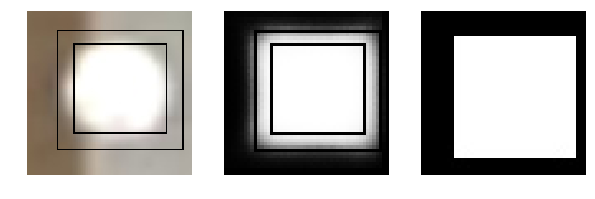

In [7]:
(x1,y1,x2,y2) = regress = output['bbox_pred'][0]
print regress

cv2.rectangle(output_img, (int(x1*2),int(y1*2)), (int(x2*2), int(y2*2)), (0,0,255), 1)

plt.subplot(1, 3, 1)
plt.imshow(output_img); plt.axis('off')

plt.subplot(1, 3, 3)
prob = caffe.io.load_image(prob_name)
plt.imshow(prob); plt.axis('off')

plt.subplot(1, 3, 2)
cv2.rectangle(sodlt, (int(x1),int(y1)), (int(x2), int(y2)), (0,0,128), 1)
plt.imshow(sodlt); plt.axis('off')

In [ ]:
def bbox_transform_inv(box, delta):

    box = box.astype(delta.dtype, copy=False)

    width = box[2] - box[0] + 1.0
    height = box[3] - box[1] + 1.0
    ctr_x = box[0] + 0.5 * width
    ctr_y = box[1] + 0.5 * height

    dx = delta[0]
    dy = delta[1]
    dw = delta[2]
    dh = delta[3]

    pred_ctr_x = dx * width + ctr_x
    pred_ctr_y = dy * height + ctr_y
    pred_w = np.exp(dw) * width
    pred_h = np.exp(dh) * height

    pred_box = np.zeros(delta.shape, dtype=delta.dtype)
    # x1
    pred_box[0] = pred_ctr_x - 0.5 * pred_w
    # y1
    pred_box[1] = pred_ctr_y - 0.5 * pred_h
    # x2
    pred_box[2] = pred_ctr_x + 0.5 * pred_w
    # y2
    pred_box[3] = pred_ctr_y + 0.5 * pred_h

    return pred_box

In [25]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

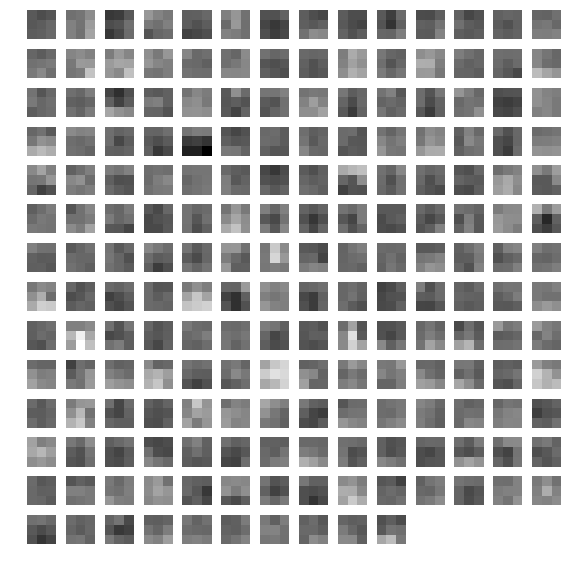

In [27]:
# the parameters are a list of [weights, biases]
#filters = net.params['conv1'][0].data
#vis_square(filters.transpose(0, 2, 3, 1))
filters = net.params['conv5'][0].data
vis_square(filters[1])
#print filters[4][3]

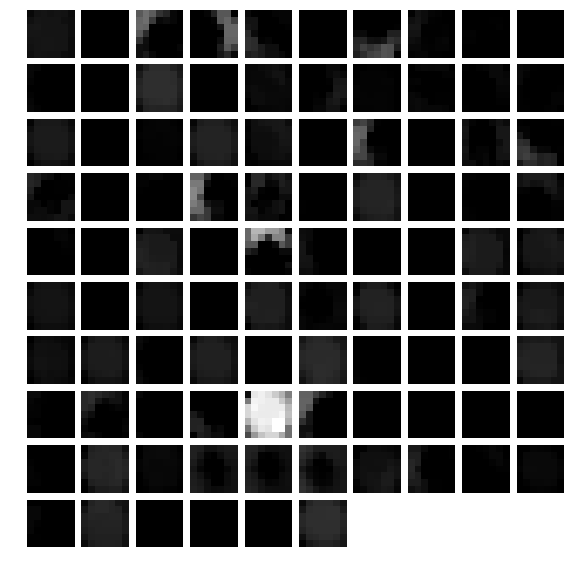

In [70]:
feat = net.blobs['roi_pool'].data[0]
vis_square(feat)

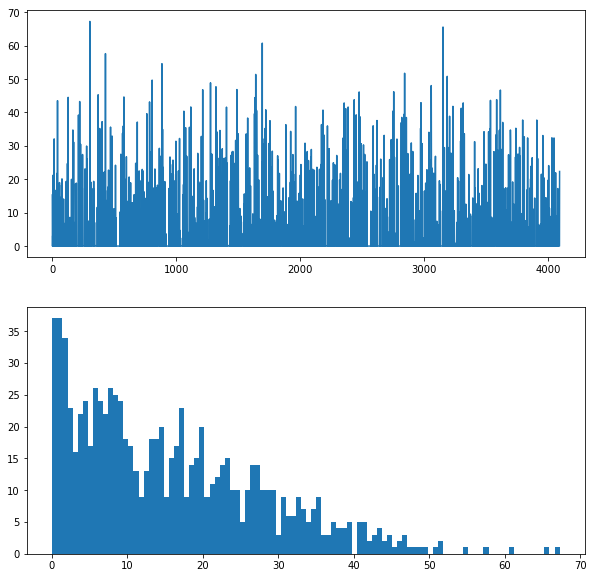

In [43]:
feat = net.blobs['regress_fc6'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

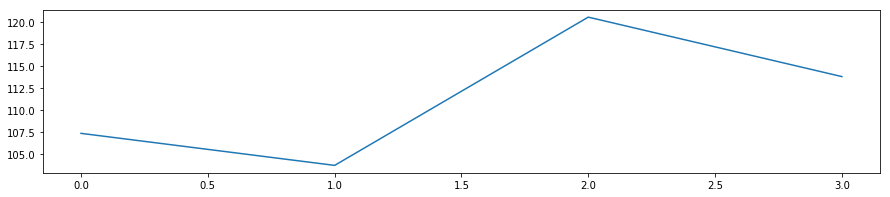

In [13]:
feat = net.blobs['my_pred'].data[0]
plt.figure(figsize=(15, 3))
plt.plot(feat.flat)

In [9]:
#speed
net.forward()  # run once before timing to set up memory
%timeit net.forward()

10 loops, best of 3: 68.6 ms per loop
